# Net Zero Pledges

This notebooks prepares data for [the donut plot with carbon neutrality pledges](https://faktaoklimatu.cz/infografiky/emisni-zavazky) of different countries. We need to combine CO2 emission data together with information about carbon neutrality pledges.

## Load prerequisities

(The prerequisities had to be already installed, e.g. ``pip install -r notebooks/requirements.txt`` in terminal.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# load matplotlibrc file with nicer settings for plots
mpl.rc_file_defaults()

## CO2 emissions data

Emissions data are loaded from EDGAR database (Emissions Database for Global Atmospheric Research) published by Joint Research Centre of European Commission. We use the newest version [EDGAR v8.0](https://edgar.jrc.ec.europa.eu/dataset_ghg80) that contains emissions data for CO2, CH4 and N2O for all countries up to 2022. The values are given in Gg (gigagrams, i.e. thousands of tonnes).

As some countries pledged to climate neutrality (net-zero emissions of all greenhouse gases) and some countries pledged only to carbon neutrality (net-zero emissions of CO2 only), we will investigate only CO2 emissions to avoid inconsistencies. For detailed explanation, see our explainer [Co přesně znamená uhlíková neutralita?](https://faktaoklimatu.cz/explainery/uhlikova-neutralita) (in Czech only).

The EDGAR files from the `Time Series (1970-2022) -> IEA-EDGAR CO2` section were downloaded and unzipped into ``../data/edgar/v8.0/``.

In [2]:
# EDGAR v6.0
edgar_co2_path = '../data/edgar/v8.0/IEA_EDGAR_CO2_1970_2022.xlsx'

edgar_cols = {
    'Country_code_A3': 'code',
    'Y_2022': 'CO2'
}

edgar = pd.read_excel(edgar_co2_path, sheet_name='TOTALS BY COUNTRY', header=9)
edgar = edgar[list(edgar_cols)].rename(columns=edgar_cols)

# Do not exclude international shipping and aviation
# edgar = edgar[~edgar['code'].isin(['SEA', 'AIR'])]

In [3]:
edgar.head()

,code,CO2
0,ABW,455.064864
1,AFG,5675.770659
2,AGO,20185.668455
3,AIA,22.819879
4,AIR,420366.479172


In [4]:
edgar['CO2'].sum()

38522011.21169735

Total world emissions of CO2 in 2022 were 38.5 billion tonnes (excluding LULUCF).

## Carbon neutrality pledges

We use the dataset compiled by [Net Zero Tracker](https://zerotracker.net). The latest snapshot at the time of writing this notebook is stored in ``../data/net-zero-tracker/``.

In [5]:
path = '../data/net-zero-tracker/snapshot_2023-11-05_22-10-11.xlsx'
net_zero = pd.read_excel(path)

In [6]:
net_zero.head()

,last_updated,id_code,name,country,geographic_region,actor_type,isin_id,race_to_zero_member,website,end_target,...,gdp_real,annual_revenue,population,industry,sector,employees,market_index,ghg,inventory_year,higher_net_zero
0,2022-05-28 08:07:58,COU-0001,Afghanistan,AFG,Western and Central Asia,Country,NaN,No,NaN,Net zero,...,8.091174e+10,NaN,40099462.0,NaN,NaN,NaN,NaN,28790000.0,2019.0,No
1,2023-05-31 13:40:37,COU-0002,Angola,AGO,Africa,Country,NaN,No,NaN,Net zero,...,2.032765e+11,NaN,34503774.0,NaN,NaN,NaN,NaN,128290000.0,2019.0,NaN
2,2023-11-01 22:20:49,COU-0003,Argentina,ARG,Latin America and the Caribbean,Country,NaN,No,NaN,Net zero,...,9.852050e+11,NaN,45276780.0,NaN,NaN,NaN,NaN,398910000.0,2019.0,NaN
3,2023-05-15 19:40:32,COU-0004,Armenia,ARM,Western and Central Asia,Country,NaN,No,NaN,Net zero,...,3.952725e+10,NaN,2790974.0,NaN,NaN,NaN,NaN,10000000.0,2019.0,NaN
4,2022-05-24 23:25:32,COU-0005,Antigua and Barbuda,ATG,Latin America and the Caribbean,Country,NaN,No,NaN,Net zero,...,1.782760e+09,NaN,93220.0,NaN,NaN,NaN,NaN,1220000.0,2019.0,NaN


The countries are keyed by alpha-3 ISO-3166 codes and the column ``end_target`` contains the type of pledge the country made. In addition the dataset contains many other rows such as net-zero pledges of companies.

In [7]:
# Filter on countries only (and remove European Union which is listed as a country with country code XXX).
net_zero = net_zero[(net_zero['actor_type'] == 'Country') & (net_zero['country'] != 'XXX')][['name', 'country', 'end_target']].copy()

# We consider a country to be committed to carbon neutrality if it set a target date for carbon neutrality, climate neutrality, net zero or zero carbon. European Union committed to net zero as the whole block, so we also consider all its members as committed to carbon neutrality.
pledges = ['Carbon neutral(ity)', 'Climate neutral', 'Net zero', 'Zero carbon']
eu = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']

net_zero['pledge'] = net_zero['end_target'].isin(pledges) | net_zero['country'].isin(eu)
net_zero = net_zero.rename(columns={'country': 'code'})

In [8]:
# There are 153 countries & regions committed to carbon neutrality.
net_zero['pledge'].sum()

153

## Data merging

The set of countries in EDGAR dataset and NetZero dataset is not identical. Let's merge the datasets together,  investigate the differences and decide how to handle them.

In [9]:
df = pd.merge(edgar, net_zero, how='outer', indicator=True)
df['pledge'] = df['pledge'].fillna(False)

In [10]:
df[df['_merge'] == 'left_only'].sort_values('CO2', ascending=False)

,code,CO2,name,end_target,pledge,_merge
174,SEA,709705.984403,NaN,NaN,False,left_only
4,AIR,420366.479172,NaN,NaN,False,left_only
204,TWN,275573.980205,NaN,NaN,False,left_only
172,SCG,56874.440553,NaN,NaN,False,left_only
87,HKG,32439.160380,NaN,NaN,False,left_only
161,PRI,12616.574854,NaN,NaN,False,left_only
143,NCL,5361.849210,NaN,NaN,False,left_only
167,REU,2736.525140,NaN,NaN,False,left_only
121,MAC,2247.400203,NaN,NaN,False,left_only
6,ANT,2046.833626,NaN,NaN,False,left_only


EDGAR database contains many countries that we do not have net zero information about. `SEA` and `AIR` denotes international shipping and aviation respectively. The only countries with substantial emissions are Taiwan (TWN), Serbia and Montenegro (SCG, it does not exist as a single country anymore) and Hong Kong (HKG). We can safely ignore the rest. 

In [11]:
df[df['_merge'] == 'right_only']

,code,CO2,name,end_target,pledge,_merge
223,MCO,NaN,Monaco,Carbon neutral(ity),True,right_only
224,AND,NaN,Andorra,Carbon neutral(ity),True,right_only
225,LIE,NaN,Liechtenstein,Emissions reduction target,False,right_only
226,MNE,NaN,Montenegro,Emissions reduction target,False,right_only
227,PSE,NaN,"Palestinian Territory, Occupied",Other,False,right_only
228,SMR,NaN,San Marino,Emissions reduction target,False,right_only
229,SRB,NaN,Serbia,Emissions reduction target,False,right_only
230,SSD,NaN,South Sudan,Net zero,True,right_only
231,EUU,NaN,European Union,Climate neutral,True,right_only


Net zero dataset contains Serbia and Montenegro correctly as two distinct countries, neither of them has a carbon neutrality pledge. Neither Taiwan or Hong Kong are included in the net zero dataset. However both these regions have already set their net-zero pledge, hence we will treat them as committed to carbon neutrality.
- [Carbon neutrality to 2050 for Hong Kong](https://www.climateready.gov.hk/files/pdf/CAP2050_leaflet_en.pdf)
- [Net zero to 2050 for Taiwan](https://www.taiwannews.com.tw/en/news/4279634)

In [12]:
df.loc[df['code'] == 'TWN', 'pledge'] = True
df.loc[df['code'] == 'HKG', 'pledge'] = True

## Aggregation and plotting

In our donut chart, we want to show only larger countries (with >1% of world CO2 emissions) with carbon neutrality pledges. We also want to show the European Union as a whole as it is the third largest emitter, just behind China and US.

In [13]:
df['CO2_pct'] = 100 * df['CO2'] / df['CO2'].sum()
df.sort_values(by='CO2', ascending=False, inplace=True)
df[df['pledge'] & (df['CO2_pct'] > 1)]

,code,CO2,name,end_target,pledge,_merge,CO2_pct
37,CHN,1.266743e+07,China,Carbon neutral(ity),True,both,32.883611
209,USA,4.853780e+06,United States of America,Net zero,True,both,12.600018
93,IND,2.693034e+06,India,Net zero,True,both,6.990897
169,RUS,1.909039e+06,Russian Federation,Carbon neutral(ity),True,both,4.955710
102,JPN,1.082645e+06,Japan,Carbon neutral(ity),True,both,2.810459
92,IDN,6.922361e+05,Indonesia,Net zero,True,both,1.796988
51,DEU,6.735953e+05,Germany,Climate neutral,True,both,1.748598
109,KOR,6.355030e+05,South Korea,Net zero,True,both,1.649714
171,SAU,6.079075e+05,Saudi Arabia,Net zero,True,both,1.578078
34,CAN,5.820729e+05,Canada,Net zero,True,both,1.511014


In [14]:
# Names of countries and categories are using the translation module to resolve their name (we needed it for the chart -- the infographics on our website is directly based on the resulting plot). We will use these dictionaries to aggregate data up to larger sets that will be displayed in the chart.
%run ./utils.ipynb
translator = Translator(locale='cz')

large_pledged = {
    translator.translate('net-zero-pledges.AUS'): ['AUS'],
    translator.translate('net-zero-pledges.BRA'): ['BRA'],
    translator.translate('net-zero-pledges.CHN'): ['CHN'],
    translator.translate('net-zero-pledges.EU'): eu,
    translator.translate('net-zero-pledges.IND'): ['IND'], 
    translator.translate('net-zero-pledges.IDN'): ['IDN'],
    translator.translate('net-zero-pledges.JPN'): ['JPN'],
    translator.translate('net-zero-pledges.ZAF'): ['ZAF'],
    translator.translate('net-zero-pledges.KOR'): ['KOR'],
    translator.translate('net-zero-pledges.CAN'): ['CAN'],
    translator.translate('net-zero-pledges.MEX'): ['MEX'],
    translator.translate('net-zero-pledges.RUS'): ['RUS'],
    translator.translate('net-zero-pledges.SAU'): ['SAU'],
    translator.translate('net-zero-pledges.TUR'): ['TUR'],
    translator.translate('net-zero-pledges.USA'): ['USA'],
}
sea_air = ['SEA', 'AIR']

large_pledged_flatten = [y for x in large_pledged.values() for y in x]
countries_with_pledge = list(df[df.pledge].code.values)
small_pledged = [x for x in countries_with_pledge if x not in large_pledged_flatten]
non_pledged = list(df[~(df.pledge | df.code.isin(sea_air) | df.code.isin(eu))].code.values)

to_display = {**large_pledged, translator.translate('net-zero-pledges.Others'): small_pledged, translator.translate('net-zero-pledges.NonPledged'): non_pledged, translator.translate('net-zero-pledges.Transport'): sea_air}

In [15]:
# Data aggregation (the naming is in Czech)
pledged = pd.DataFrame([(k, df[df.code.isin(v)]['CO2'].sum() / 1e6) for k, v in to_display.items()], columns=['region', 'co2_emissions'])
co2_all = pledged['co2_emissions'].sum()
pledged['share'] = pledged['co2_emissions'] / co2_all
pledged['label'] = pledged.apply(lambda x: '{} {:.3g} %'.format(x['region'], x['share'] * 100).replace('.', ','), axis=1)
# Sort pledged countries by share of emissions, but keep the last
# three entries -- others, not committed and international transport --
# in place.
pledged = pd.concat(
    [pledged[:-3].sort_values(by='share', ascending=False), pledged[-3:]],
    ignore_index=True
)

pledged

,region,co2_emissions,share,label
0,Čína,12.667428,0.328836,"Čína 32,9 %"
1,USA,4.853780,0.126000,"USA 12,6 %"
2,EU-27,2.804806,0.072810,"EU-27 7,28 %"
3,Indie,2.693034,0.069909,"Indie 6,99 %"
4,Rusko,1.909039,0.049557,"Rusko 4,96 %"
5,Japonsko,1.082645,0.028105,"Japonsko 2,81 %"
6,Indonésie,0.692236,0.017970,"Indonésie 1,8 %"
7,Jižní Korea,0.635503,0.016497,"Jižní Korea 1,65 %"
8,Saudská Arábie,0.607908,0.015781,"Saudská Arábie 1,58 %"
9,Kanada,0.582073,0.015110,"Kanada 1,51 %"


In [16]:
countries_with_pledges = df['pledge'].sum() - 2  # We do not count Taiwan and Hong Kong as sovereign countries here.
CO2_pct_covered_by_pledges = df[df['pledge']]['CO2_pct'].sum()

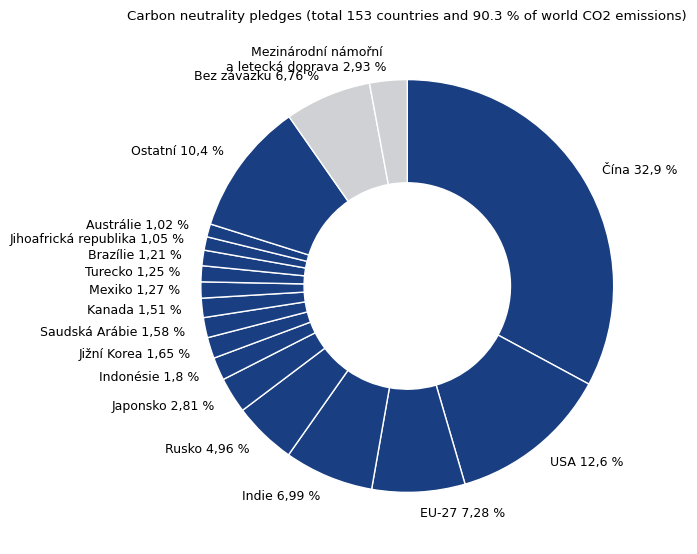

In [17]:
# We use blue color for pledges and gray for other countries
# and international transport.
num_colors = len(pledged) - 2
colors = ['#193f82'] * num_colors + ['#cfd1d4'] * 2

_, ax = plt.subplots()
plt.pie(pledged['co2_emissions'],
        colors=colors,
        labels=pledged['label'],
        counterclock=False,
        radius=1,
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white', 'width': 0.5})

# ax.set_title(f'Carbon neutrality pledges (total {countries_with_pledges} countries and {CO2_pct_covered_by_pledges:.1f} % of world CO2 emissions)')
ax.set_title(translator.translate('net-zero-pledges.title', countries=countries_with_pledges, co2pct='{:.1f}'.format(CO2_pct_covered_by_pledges)))

# Save graph as svg
plt.savefig("../outputs/net-zero-pledges.svg")